## Preliminaries and Setup

#### Import necessary moduels

In [140]:
import getpass
import numpy as np
import matplotlib.pyplot as plt
import axs
import pyspark.sql.functions as sparkfunc
import dipper
from pyspark.sql import SparkSession

%matplotlib notebook
%matplotlib inline

#### Define functions used in this notebook

In [3]:
def skew_normal(x, skew, loc, xscale, yscale, offset):
    from scipy.stats import skewnorm
    _dist = skewnorm(skew, loc=loc, scale=xscale)
    return yscale * _dist.pdf(x) + offset

In [115]:
def top_hat(x, loc, width, depth, offset):
    import numpy as np
    x = np.array(x)
    left = loc - width / 2
    right = loc + width / 2
    outside = (x < left) | (x > right)
    inside = np.logical_not(outside)
    
    y = np.zeros(x.shape)
    y[outside] = offset
    y[inside] = offset + depth
    
    return y

In [118]:
def plot_row(row):
    dip = row['dip']

    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    window_r = row['window_r']
    #plt.errorbar(window_r['x'], window_r['y'], window_r['yerr'], fmt='.')
    plt.errorbar(row['mjd_r'], row['mag_r'], row['magerr_r'], fmt='o', c='C3')
    
    
    start_mjd = dip['window_start_mjd']
    end_mjd = dip['window_end_mjd']
    pad = end_mjd - start_mjd
    
    plt.axvline(start_mjd, c='k', ls='--')
    plt.axvline(end_mjd, c='k', ls='--')
    
    plt.xlim(start_mjd - pad, end_mjd + pad)
    x = np.linspace(start_mjd - pad, end_mjd + pad, 1000)
    
    popt = row['fit_r_skew_normal']['popt']
    model = skew_normal(x, *popt)
    plt.plot(x, model, label=f'Skew normal fit - {row["model_error_around_dip_r_skew_normal"][1]:.2f}')
    
    popt = row['fit_r_top_hat']['popt']
    model = top_hat(x, *popt)
    plt.plot(x, model, label=f'Top hat fit - {row["model_error_around_dip_r_top_hat"][1]:.2f}')
    

    ax.set_xlabel('MJD')
    ax.set_title('objid %d' % row['ps1_objid'])
    plt.gca().invert_yaxis()
    plt.legend()
    print(row['ps1_objid'])

In [6]:
def print_out_info(df_try):
    for idx in df_try:
        location = sig_df[sig_df['ps1_objid']==idx].index
        chi_skew_temp = np.array(sig_df[sig_df['ps1_objid']==idx]['model_error_around_dip_r_skew_normal'])
        top_hat_temp = np.array(sig_df[sig_df['ps1_objid']==idx]['model_error_around_dip_r_top_hat'])
        x_scale_temp = np.array(sig_df[sig_df['ps1_objid']==idx]['fit_r_skew_normal'])
        print(f'objid {idx}')
        print(f'Skew normal fit:\t{chi_skew_temp[0][1]}')
        print(f'Top hat fit:\t{top_hat_temp[0][1]}')
        print(f'x_scale:\t{x_scale_temp[0]["popt"][2]}')
        plot_row(sig_df.iloc[0])

In [443]:
def plot_top_hat_row(row):
    dip = row['dip']

    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    window_r = row['window_r']
    plt.errorbar(row['mjd_r'], row['mag_r'], row['magerr_r'], fmt='o', c='C3')
    
    
    start_mjd = dip['window_start_mjd']
    end_mjd = dip['window_end_mjd']
    pad = end_mjd - start_mjd
    
    plt.axvline(start_mjd, c='k', ls='--')
    plt.axvline(end_mjd, c='k', ls='--')
    
    plt.xlim(start_mjd - pad, end_mjd + pad)
    popt = [float(i) for i in row['fit_r']['popt']]
    x = np.linspace(start_mjd - pad, end_mjd + pad, 1000)
    model = top_hat(x, *popt)
    plt.plot(x, model, label=f'Top hat fit - {row["dip"]["significance"]}')
    

    ax.set_xlabel('MJD')
    ax.set_title('objid %d' % row['ps1_objid'])
    plt.gca().invert_yaxis()
    plt.legend()
    print(row['ps1_objid'])
    print(f'top hat fit: {row["dip"]["significance"]}')
    print(f'length: {popt[1]}')
    print()

#### Load Steven's data

In [7]:
# set the params of the spark session
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [ ]:
#load the data from the catalog
catalog = axs.AxsCatalog(spark)

In [ ]:
#For assymetric dips
joined_df = catalog.load("6_4_20_stevengs_top_hat_and_skew_normal_fits_r_band")

In [31]:
#for top-hat fits
top_hat = catalog.load("8_5_20_stevengs_top_hat_fits_r_band")

## EDA for skew normal data

In [9]:
df = joined_df.toPandas()

In [10]:
df.head()

,fit_r_top_hat,model_error_in_dip_r_top_hat,model_error_around_dip_r_top_hat,model_error_r_top_hat,ps1_objid,ra,dec,zone,mjd_r,mag_r,magerr_r,dip,window_r,fit_r_skew_normal,dip_window_r,model_error_in_dip_r_skew_normal,around_dip_window_r,model_error_around_dip_r_skew_normal,model_error_r_skew_normal
0,"((OK, True, 0.00099945068359375), [58282.40234...","(247.6127166748047, 1.0672962665557861)","(394.15240478515625, 1.6354870796203613)","(2046.572509765625, 4.5887274742126465)",88492547744402750,254.774445,-16.256347,4424,"[58289.296701411105, 58505.56163191111, 58289....","[14.18539047241211, 14.21023941040039, 14.1802...","[0.008864653296768665, 0.008924957364797592, 0...","(58282.18359375, 58271.09765625, 58293.7070312...","([58289.296875, 58289.296875, 58289.296875, 58...","((OK, True, 0.06724286079406738), [-46257.9218...","([58289.296875, 58289.296875, 58289.296875, 58...","(247.902099609375, 1.073169231414795)","([58289.296875, 58289.296875, 58289.296875, 58...","(402.0196228027344, 1.675081729888916)","(1538.3634033203125, 3.456996440887451)"
1,"((OK, True, 0.0009999275207519531), [58670.484...","(923.65087890625, 5.920839309692383)","(1042.3411865234375, 5.855849742889404)","(1082.382568359375, 5.696750640869141)",88492616365368548,261.636494,-16.251513,4424,"[58694.26563661111, 58694.266076411106, 58694....","[19.338125228881836, 19.897186279296875, 19.49...","[0.07690298557281494, 0.10945793241262436, 0.0...","(58668.19140625, 58654.1796875, 58686.78515625...","([58694.265625, 58694.265625, 58694.296875, 58...","((OK, True, 0.5732746124267578), [-442.1985778...","([58658.25390625, 58658.25390625, 58658.273437...","(801.748779296875, 5.172573089599609)","([58694.265625, 58694.265625, 58694.296875, 58...","(932.617919921875, 5.2690277099609375)","(1002.944580078125, 5.30658483505249)"
2,"((OK, True, 0.0012252330780029297), [58663.882...","(668.8413696289062, 4.371512413024902)","(867.9769287109375, 4.903824329376221)","(893.7521362304688, 4.831092357635498)",88492647084704897,264.708448,-16.254534,4424,"[58668.269270811106, 58668.26972221111, 58217....","[18.694232940673828, 18.403799057006836, 18.49...","[0.05746031180024147, 0.04840732365846634, 0.0...","(58665.94140625, 58645.3828125, 58682.37890625...","([58668.26953125, 58668.26953125, 58669.21875,...","((OK, True, 0.38926124572753906), [4.428214550...","([58668.26953125, 58668.26953125, 58669.21875,...","(666.1785278320312, 4.382753372192383)","([58668.26953125, 58668.26953125, 58669.21875,...","(799.7885131835938, 4.544252872467041)","(829.135498046875, 4.506171226501465)"
3,"((OK, True, 0.0009043216705322266), [58670.613...","(290.2123107910156, 2.638293743133545)","(726.5582275390625, 3.823990821838379)","(781.9889526367188, 3.8904924392700195)",88502659022770783,265.902111,-16.249697,4424,"[58723.210879611106, 58662.25165511111, 58723....","[20.32710075378418, 20.458742141723633, 20.163...","[0.13722196221351624, 0.13952502608299255, 0.1...","(58669.66015625, 58656.98046875, 58684.2460937...","([58723.2109375, 58662.25, 58723.2109375, 5866...","((OK, True, 0.9714505672454834), [-0.979012727...","([58662.25, 58662.26953125, 58662.28125, 58662...","(286.48602294921875, 2.628312349319458)","([58723.2109375, 58662.25, 58723.2109375, 5866...","(735.026611328125, 3.8890295028686523)","(790.6541748046875, 3.953270673751831)"
4,"((OK, True, 0.0007274150848388672), [58670.960...","(804.3997802734375, 9.930861473083496)","(832.2371215820312, 9.247078895568848)","(854.6178588867188, 8.632503509521484)",88492659738601532,265.973936,-16.257403,4424,"[58640.27548611111, 58338.19006941111, 58643.2...","[19.86772346496582, 20.279481887817383, 20.164...","[0.11113061755895615, 0.1357736587524414, 0.13...","(58678.40234375, 58635.7734375, 58706.1484375,...","([58640.27734375, 58643.2734375, 58646.2734375...","((OK, True, 3.272620439529419), [-0.8793529868...","([58640.27734375, 58643.2734375, 58646.2734375...","(804.0816040039062, 10.051019668579102)","([58640.27734375, 58643

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55345 entries, 0 to 55344
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   fit_r_top_hat                         55345 non-null  object 
 1   model_error_in_dip_r_top_hat          55345 non-null  object 
 2   model_error_around_dip_r_top_hat      55345 non-null  object 
 3   model_error_r_top_hat                 55345 non-null  object 
 4   ps1_objid                             55345 non-null  int64  
 5   ra                                    55345 non-null  float64
 6   dec                                   55345 non-null  float64
 7   zone                                  55345 non-null  int64  
 8   mjd_r                                 55345 non-null  object 
 9   mag_r                                 55345 non-null  object 
 10  magerr_r                              55345 non-null  object 
 11  dip            

## Prep and cuts for asymmetric dips

In [12]:
# Sort by significance
sig = [i['significance'] for i in df['dip']]
sig_df = df.iloc[np.argsort(sig)[::-1]]

In [13]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

chisq_skew = np.array([i[1] for i in sig_df['model_error_around_dip_r_skew_normal']])
chisq_tophat = np.array([i[1] for i in sig_df['model_error_around_dip_r_top_hat']])
skew = np.array([i['popt'][0] for i in sig_df['fit_r_skew_normal']])
xscale = np.array([i['popt'][2] for i in sig_df['fit_r_skew_normal']])
yscale = np.array([i['popt'][3] for i in sig_df['fit_r_skew_normal']])

In [22]:
cut = (
    (chisq_skew < 5)
    & (np.abs(skew) > 2)
    & (np.abs(xscale) < 50)
    & (chisq_tophat - chisq_skew > 2)
    #& (np.abs(yscale) > 10.)
)

In [23]:
np.sum(cut)

817

133592971966272490
131123129860725804
78632590997885819
174493453470111606
154023044174687389
107322831484070424
174523510301184558
144012972583475087
175643379705894050
170550148269843515


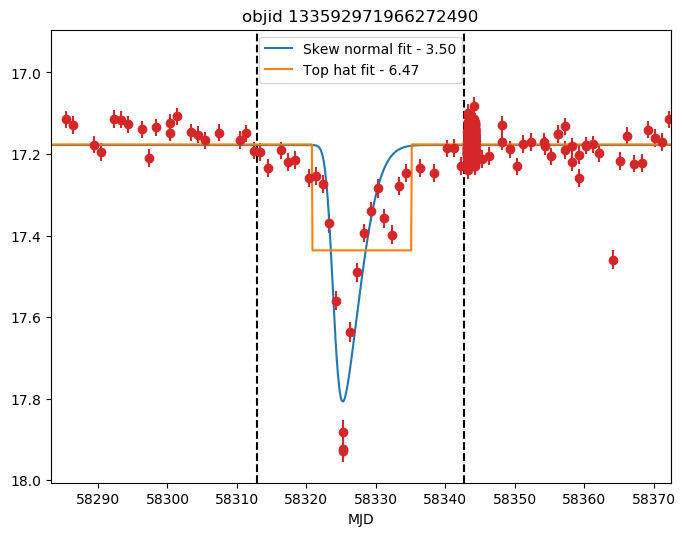

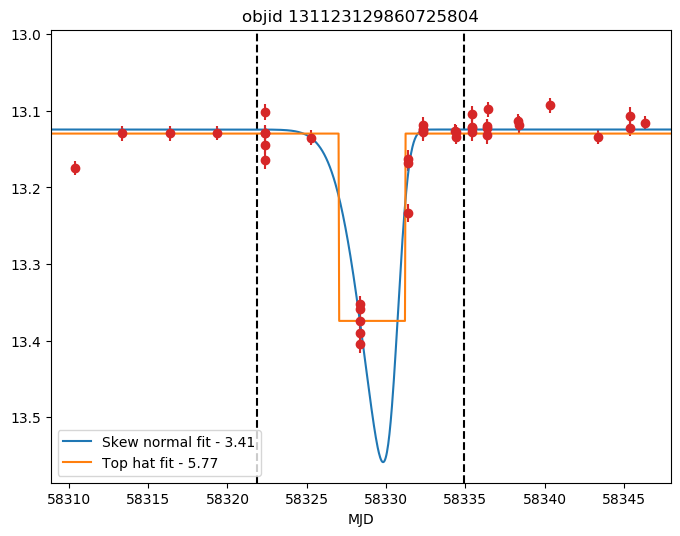

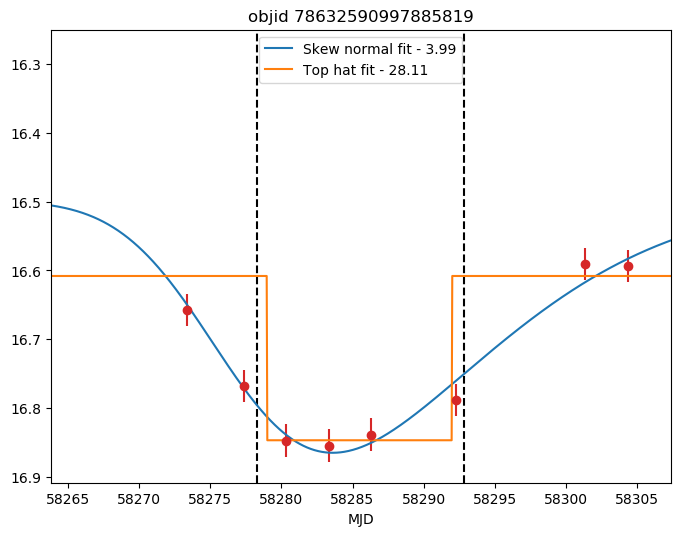

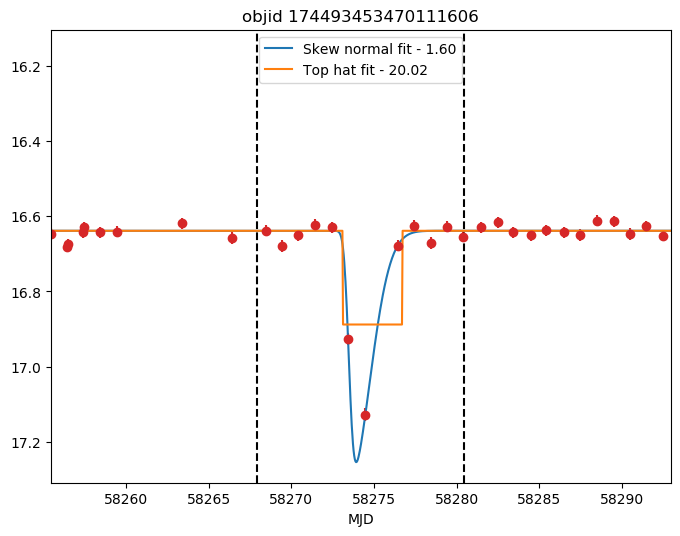

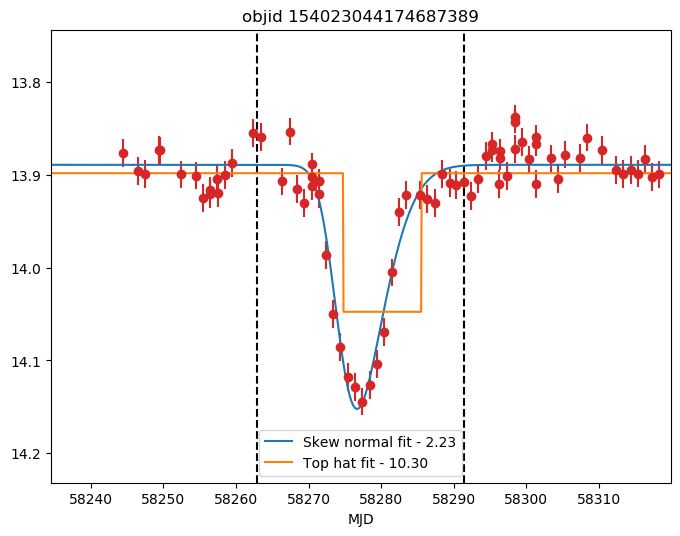

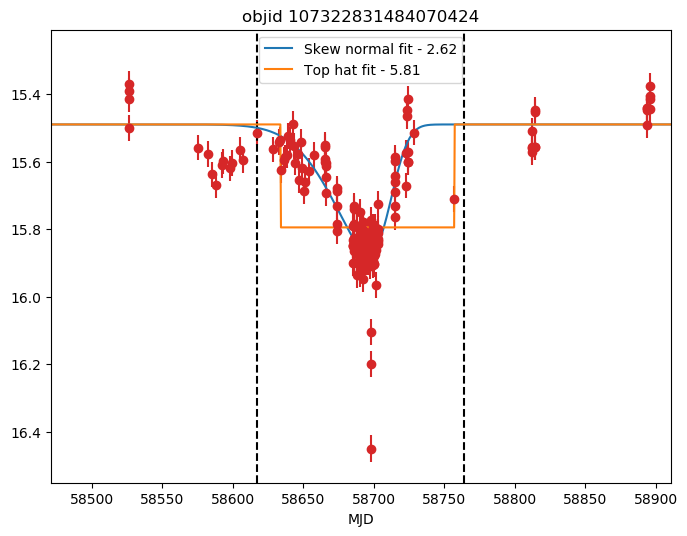

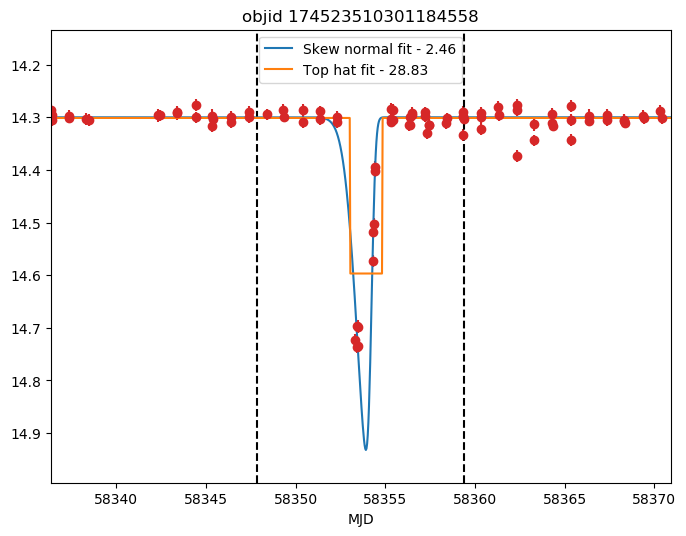

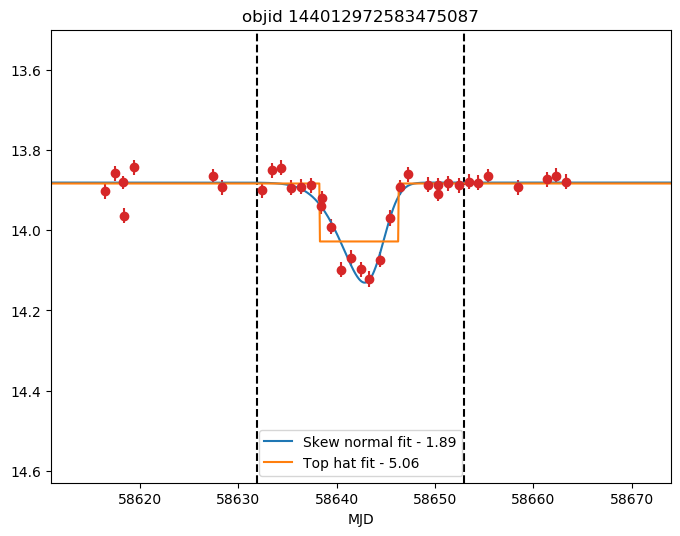

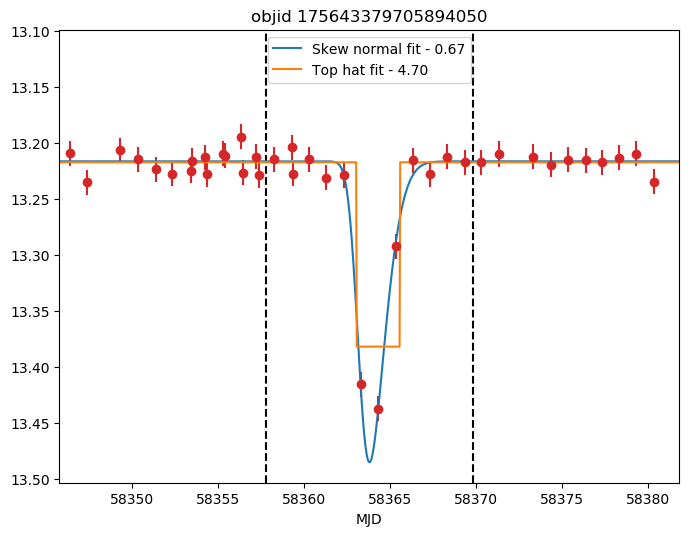

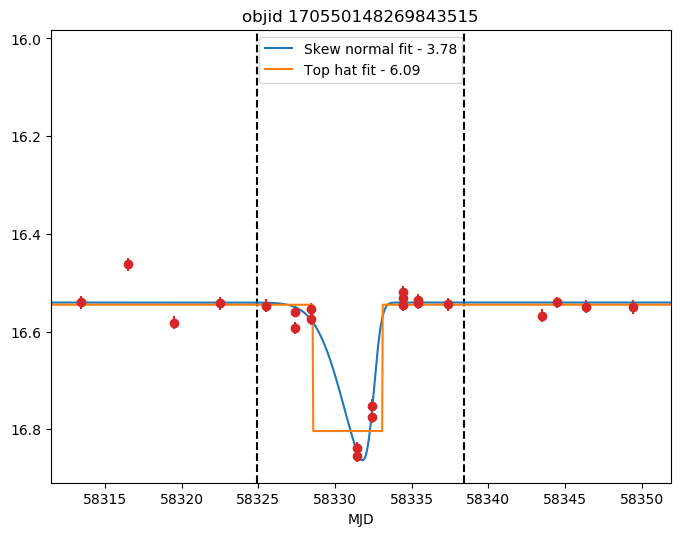

In [28]:
for i in range(10):
    plot_row(sig_df[cut].iloc[i])

objid 161643482853137142
Skew normal fit:	3.6836647987365723
Top hat fit:	5.7691192626953125
x_scale:	5.530174255371094
132550947954943855


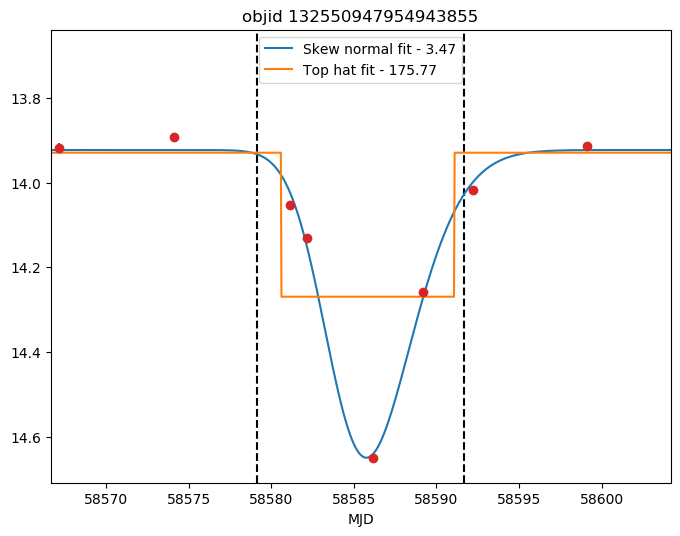

In [95]:
df_try = [161643482853137142]
print_out_info(df_try)

## EDA for top-hats

In [32]:
df_top_hat = top_hat.toPandas()

In [33]:
df_top_hat.head()

,ps1_objid,ra,dec,zone,dup,mjd_r,mag_r,magerr_r,dip,window_r,fit_r,dip_window_r,model_error_in_dip_r,around_dip_window_r,model_error_around_dip_r,model_error_r
0,88492547744402750,254.774445,-16.256347,4424,0,"[58289.296701411105, 58505.56163191111, 58289....","[14.18539047241211, 14.21023941040039, 14.1802...","[0.008864653296768665, 0.008924957364797592, 0...","(58282.18359375, 58271.09765625, 58293.7070312...","([58289.296875, 58289.296875, 58289.296875, 58...","((OK, True, 0.0009300708770751953), [58282.402...","([58289.296875, 58289.296875, 58289.296875, 58...","(247.6127166748047, 1.0672962665557861)","([58289.296875, 58289.296875, 58289.296875, 58...","(394.15240478515625, 1.6354870796203613)","(2046.572509765625, 4.5887274742126465)"
1,88492616365368548,261.636494,-16.251513,4424,0,"[58694.26563661111, 58694.266076411106, 58694....","[19.338125228881836, 19.897186279296875, 19.49...","[0.07690298557281494, 0.10945793241262436, 0.0...","(58668.19140625, 58654.1796875, 58686.78515625...","([58694.265625, 58694.265625, 58694.296875, 58...","((OK, True, 0.0009021759033203125), [58670.484...","([58658.25390625, 58658.25390625, 58658.273437...","(923.65087890625, 5.920839309692383)","([58694.265625, 58694.265625, 58694.296875, 58...","(1042.3411865234375, 5.855849742889404)","(1082.382568359375, 5.696750640869141)"
2,88492647084704897,264.708448,-16.254534,4424,0,"[58668.269270811106, 58668.26972221111, 58217....","[18.694232940673828, 18.403799057006836, 18.49...","[0.05746031180024147, 0.04840732365846634, 0.0...","(58665.94140625, 58645.3828125, 58682.37890625...","([58668.26953125, 58668.26953125, 58669.21875,...","((OK, True, 0.0009152889251708984), [58663.882...","([58668.26953125, 58668.26953125, 58669.21875,...","(668.8413696289062, 4.371512413024902)","([58668.26953125, 58668.26953125, 58669.21875,...","(867.9769287109375, 4.903824329376221)","(893.7521362304688, 4.831092357635498)"
3,88502659022770783,265.902111,-16.249697,4424,1,"[58723.210879611106, 58662.25165511111, 58723....","[20.32710075378418, 20.458742141723633, 20.163...","[0.13722196221351624, 0.13952502608299255, 0.1...","(58669.66015625, 58656.98046875, 58684.2460937...","([58723.2109375, 58662.25, 58723.2109375, 5866...","((OK, True, 0.0011773109436035156), [58670.613...","([58662.25, 58662.26953125, 58662.28125, 58662...","(290.2123107910156, 2.638293743133545)","([58723.2109375, 58662.25, 58723.2109375, 5866...","(726.5582275390625, 3.823990821838379)","(781.9889526367188, 3.8904924392700195)"
4,88492659738601532,265.973936,-16.257403,4424,0,"[58640.27548611111, 58338.19006941111, 58643.2...","[19.86772346496582, 20.279481887817383, 20.164...","[0.11113061755895615, 0.1357736587524414, 0.13...","(58678.40234375, 58635.7734375, 58706.1484375,...","([58640.27734375, 58643.2734375, 58646.2734375...","((OK, True, 0.0008547306060791016), [58670.960...","([58640.27734375, 58643.2734375, 58646.2734375...","(804.3997802734375, 9.930861473083496)","([58640.27734375, 58643.2734375, 58646.2734375...","(832.2371215820312, 9.247078895568848)","(854.6178588867188, 8.632503509521484)"


In [34]:
df_top_hat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71764 entries, 0 to 71763
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ps1_objid                 71764 non-null  int64  
 1   ra                        71764 non-null  float64
 2   dec                       71764 non-null  float64
 3   zone                      71764 non-null  int64  
 4   dup                       71764 non-null  int32  
 5   mjd_r                     71764 non-null  object 
 6   mag_r                     71764 non-null  object 
 7   magerr_r                  71764 non-null  object 
 8   dip                       71764 non-null  object 
 9   window_r                  71764 non-null  object 
 10  fit_r                     71764 non-null  object 
 11  dip_window_r              71764 non-null  object 
 12  model_error_in_dip_r      71764 non-null  object 
 13  around_dip_window_r       71764 non-null  object 
 14  model_

## Prep and cuts for top-hat fits

In [419]:
df_top_hat.iloc[0]['dip']['significance']

5.271639347076416

In [106]:
# Sort by significance
sig = [i['significance'] for i in df_top_hat['dip']]
sig_df_top_hat = df_top_hat.iloc[np.argsort(sig)]

In [161]:
sig_df_top_hat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71764 entries, 5755 to 59456
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ps1_objid                 71764 non-null  int64  
 1   ra                        71764 non-null  float64
 2   dec                       71764 non-null  float64
 3   zone                      71764 non-null  int64  
 4   dup                       71764 non-null  int32  
 5   mjd_r                     71764 non-null  object 
 6   mag_r                     71764 non-null  object 
 7   magerr_r                  71764 non-null  object 
 8   dip                       71764 non-null  object 
 9   window_r                  71764 non-null  object 
 10  fit_r                     71764 non-null  object 
 11  dip_window_r              71764 non-null  object 
 12  model_error_in_dip_r      71764 non-null  object 
 13  around_dip_window_r       71764 non-null  object 
 14  mod

In [131]:
row = sig_df_top_hat.iloc[0]
row['fit_r']

Row(info=Row(message='OK', good=True, runtime=0.0007491111755371094), popt=[58460.84375, 8.6796875, 0.0233599916100502, 16.265886306762695], pcov=[[inf, inf, inf, inf], [inf, inf, inf, inf], [inf, inf, inf, inf], [inf, inf, inf, inf]], p0=[58460.84375, 8.6796875, 0.8905507326126099, 16.261842727661133])

In [420]:
xscale = np.array([i['popt'][1] for i in sig_df_top_hat["fit_r"]])
yscale = np.array([i['popt'][2] for i in sig_df_top_hat["fit_r"]])
top_hat_value = np.array([i['significance'] for i in sig_df_top_hat['dip']])

In [463]:
def top_hat_cut(start_days, end_days, fit_value, depth):
    cut = (
        (np.abs(xscale) > start_days)
        & (np.abs(xscale) < end_days)
        & (np.abs(top_hat_value) <= fit_value)
        & (np.abs(yscale) < depth)
        & (np.abs(yscale) > 0.15)
    )
    return cut

In [464]:
cut_top_hat = top_hat_cut(start_days=35, end_days=50, fit_value=7, depth=5)

In [465]:
top_hat_total = np.sum(cut_top_hat)
top_hat_total

441

92722833704871378
top hat fit: 5.352175235748291
length: 49.77734375

116472906382874840
top hat fit: 5.355439186096191
length: 38.98828125

83642662317620228
top hat fit: 5.364229202270508
length: 41.19140625

142442966572149708
top hat fit: 5.370077133178711
length: 38.25390625

111772861145984975
top hat fit: 5.373724460601807
length: 42.296875

111432915108258563
top hat fit: 5.3806352615356445
length: 47.4140625

129922970067077761
top hat fit: 5.385785102844238
length: 40.2109375

89342658778647606
top hat fit: 5.393836498260498
length: 39.51171875

89272665422822161
top hat fit: 5.396946430206299
length: 44.3828125

124942869350634426
top hat fit: 5.398271083831787
length: 41.8828125

85772615189717051
top hat fit: 5.3992719650268555
length: 41.84375

95252801881870458
top hat fit: 5.402048587799072
length: 36.71484375

84522661324305827
top hat fit: 5.408048629760742
length: 40.51953125

100642816773744263
top hat fit: 5.408619403839111
length: 40.03125

106252813322777706
top 

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

83372660738712855
top hat fit: 5.470109462738037
length: 41.34765625

140712921624030976
top hat fit: 5.471982955932617
length: 36.453125

89112679061764103
top hat fit: 5.472639560699463
length: 41.79296875

83992596336223076
top hat fit: 5.477708339691162
length: 37.11328125

87992659413980860
top hat fit: 5.479525566101074
length: 48.25

101872819316316258
top hat fit: 5.481544494628906
length: 36.91015625

152282973739105582
top hat fit: 5.493975639343262
length: 35.36328125



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

120102928193734865
top hat fit: 5.498053073883057
length: 36.140625

112412879053723360
top hat fit: 5.498593330383301
length: 35.8046875

83442614486288784
top hat fit: 5.50115442276001
length: 39.1796875

99492837625559212
top hat fit: 5.503415584564209
length: 38.08984375

125022862253939987
top hat fit: 5.510649681091309
length: 44.66015625

83822662572072662
top hat fit: 5.523727893829346
length: 39.5

83822662572072662
top hat fit: 5.523727893829346
length: 39.5



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

106762787985976689
top hat fit: 5.532308101654053
length: 41.8359375

86082594735636441
top hat fit: 5.533352851867676
length: 40.43359375

106102855233248295
top hat fit: 5.534532070159912
length: 36.65625

119182842925839337
top hat fit: 5.542697906494141
length: 44.828125

100872801759619499
top hat fit: 5.550947666168213
length: 49.03515625

97682832997660268
top hat fit: 5.551177978515625
length: 36.21875

97682833000380137
top hat fit: 5.551177978515625
length: 36.21875



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

100572824291995695
top hat fit: 5.5602521896362305
length: 45.2734375

111452861087069498
top hat fit: 5.560776233673096
length: 48.84765625

114902919524128799
top hat fit: 5.560861110687256
length: 37.7265625



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


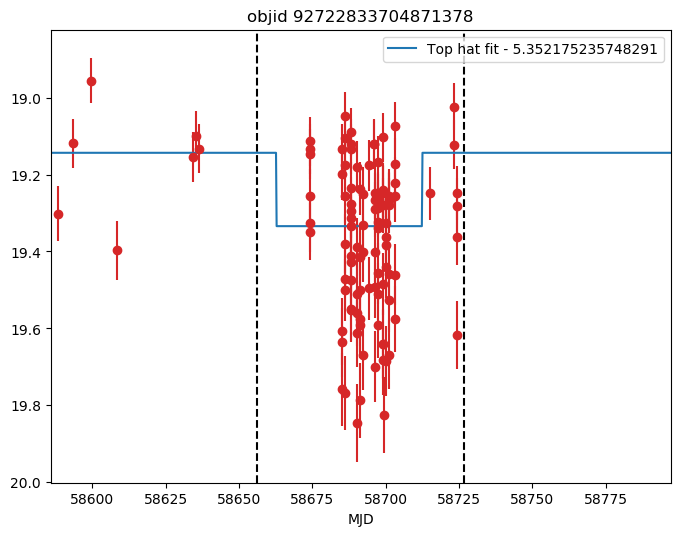

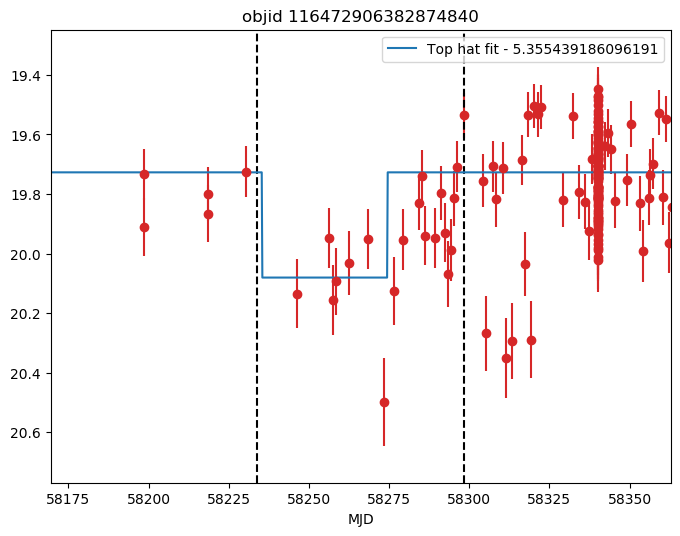

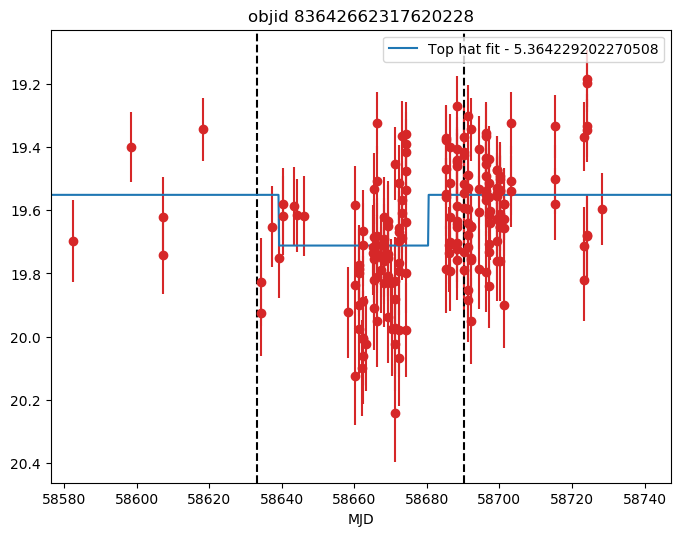

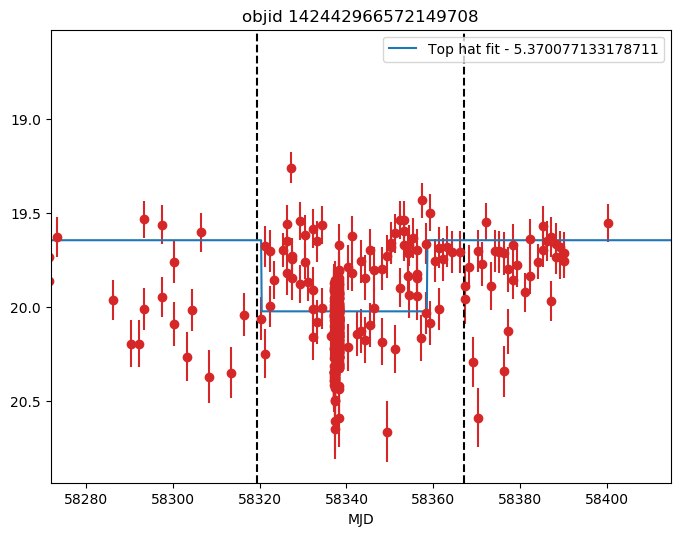

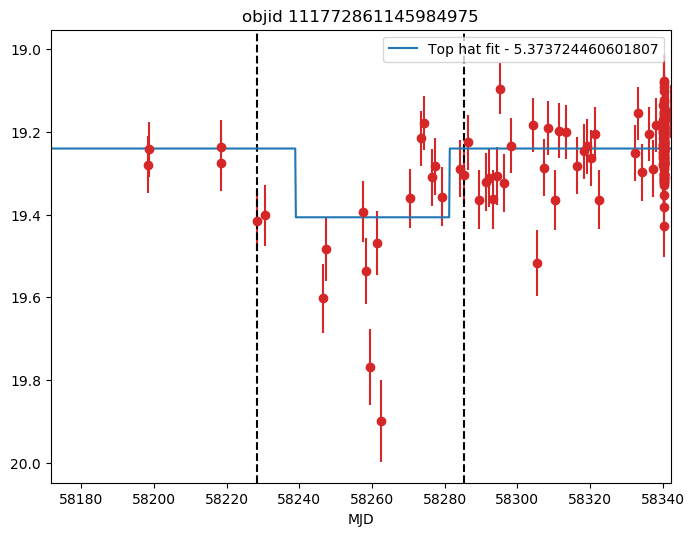

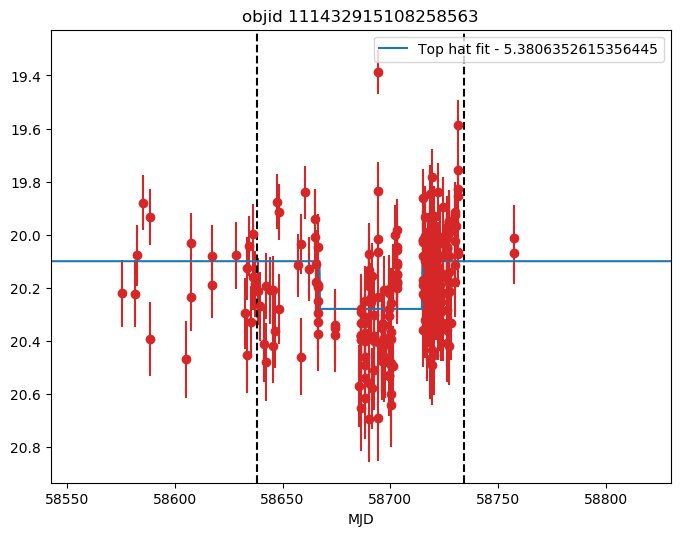

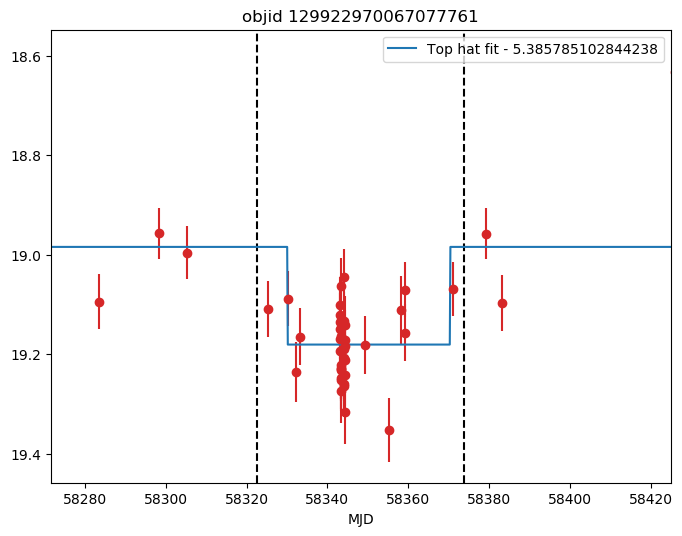

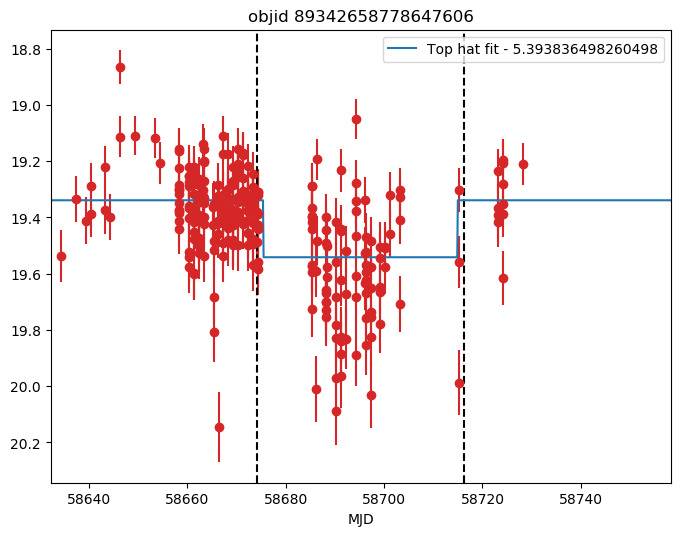

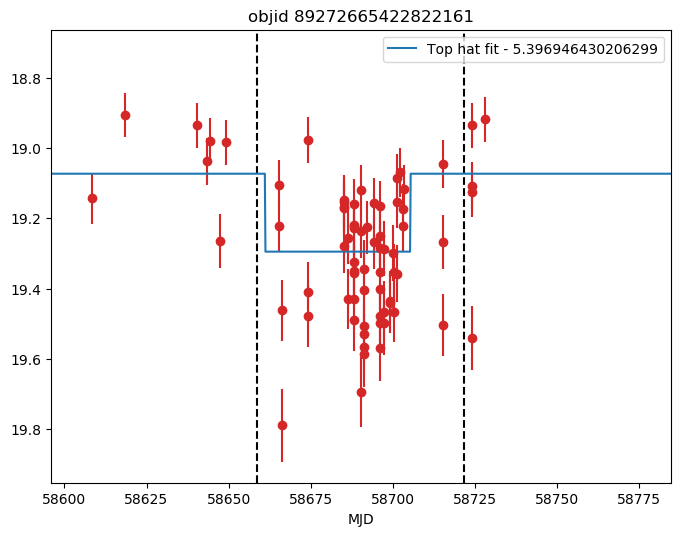

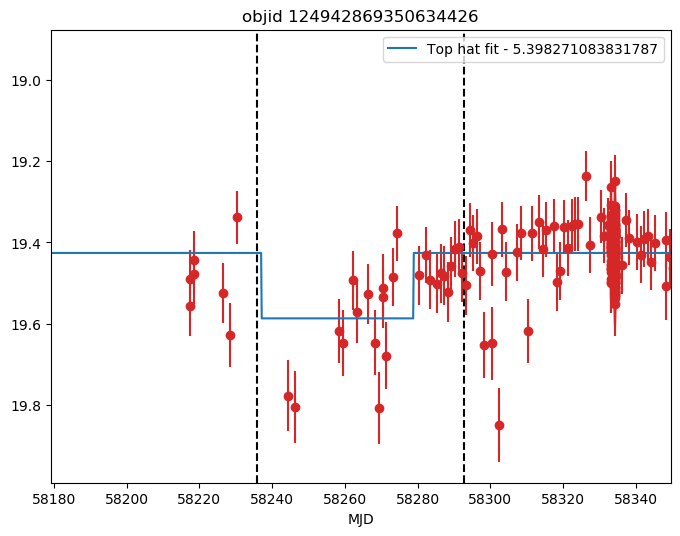

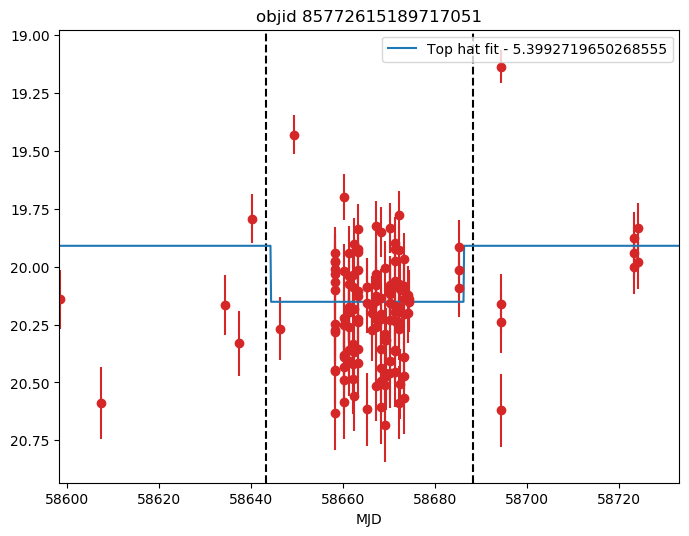

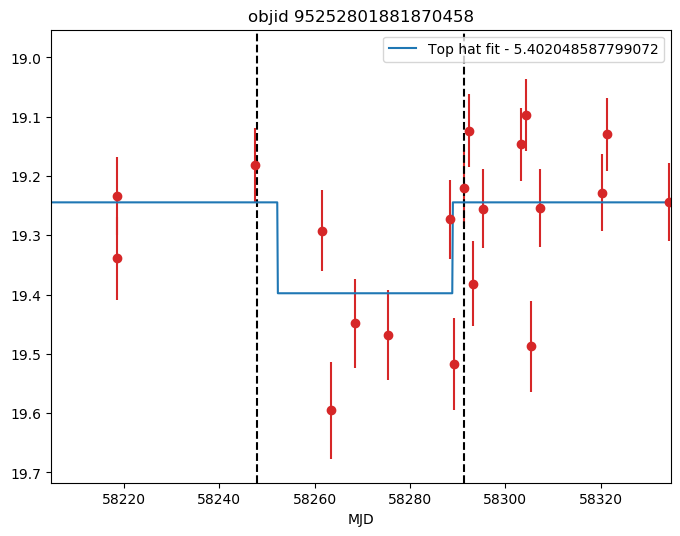

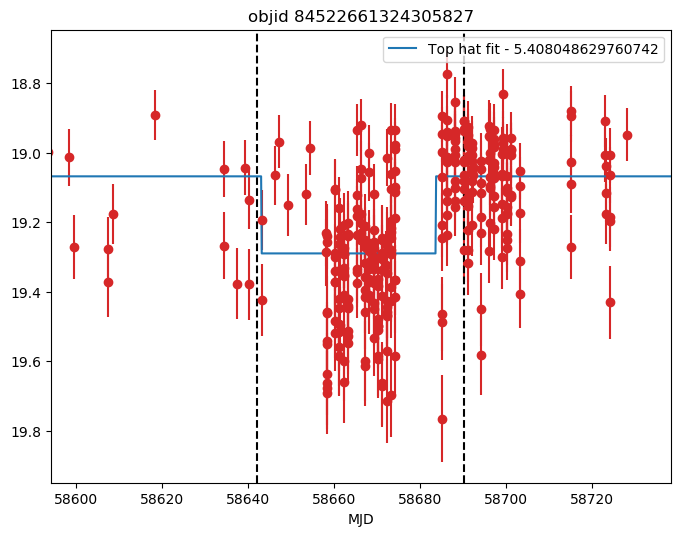

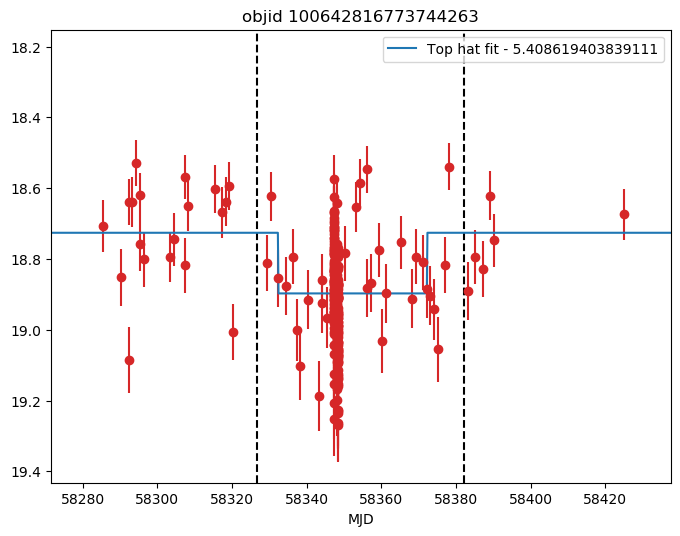

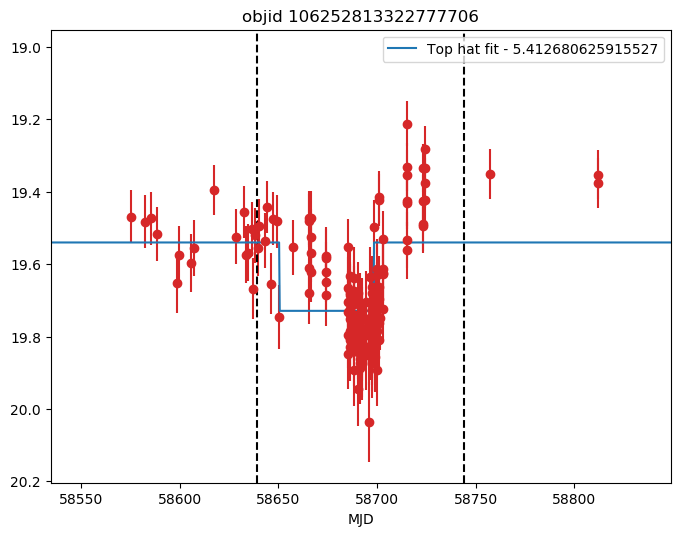

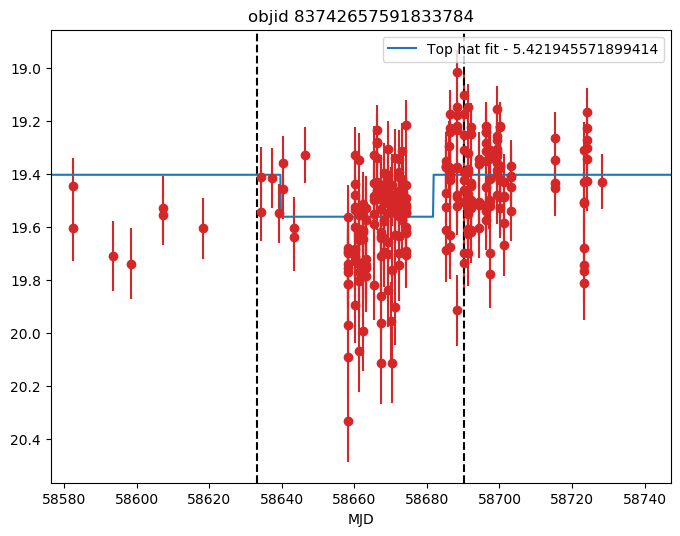

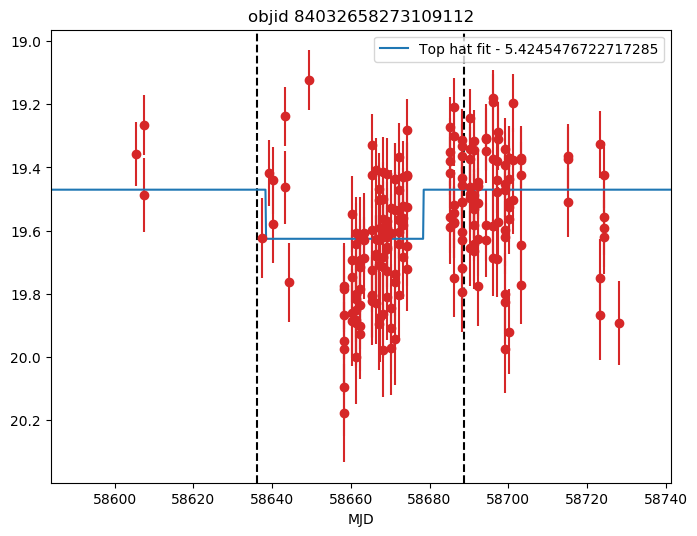

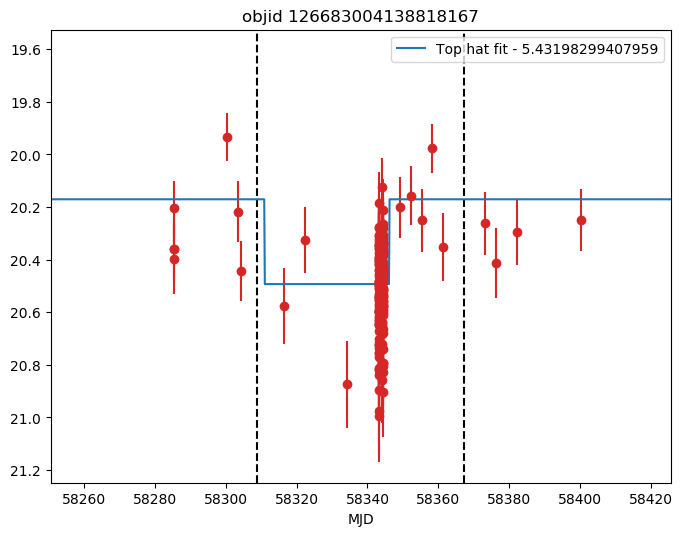

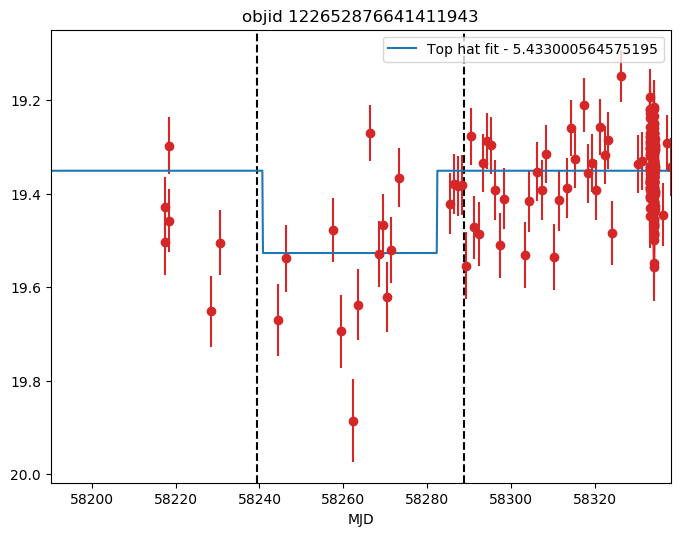

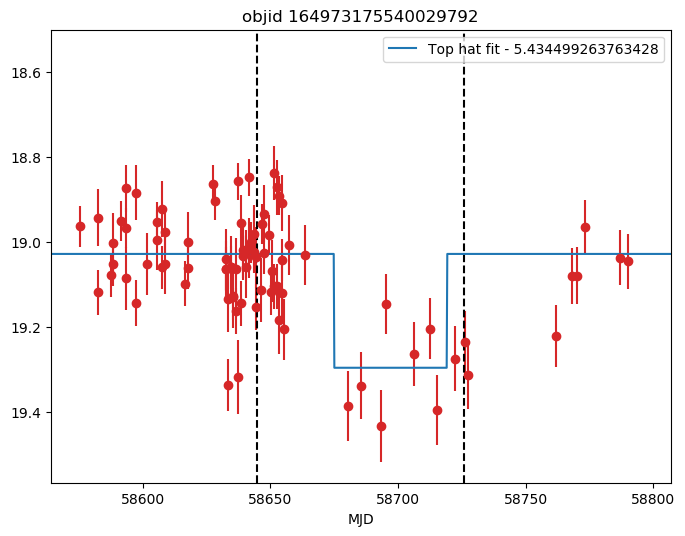

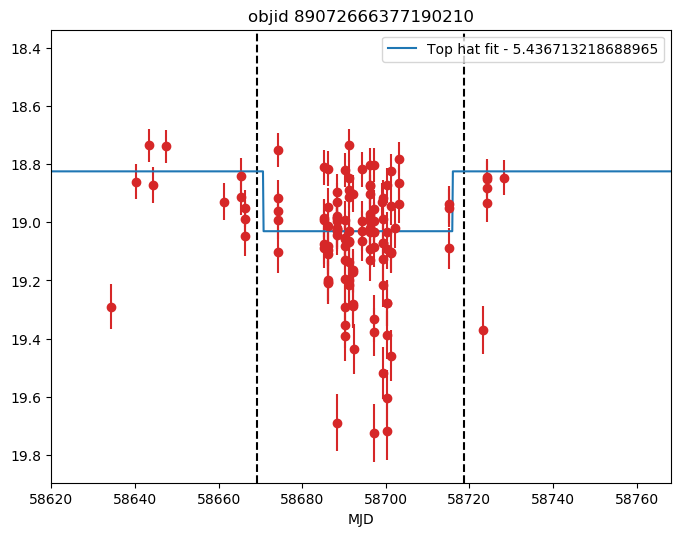

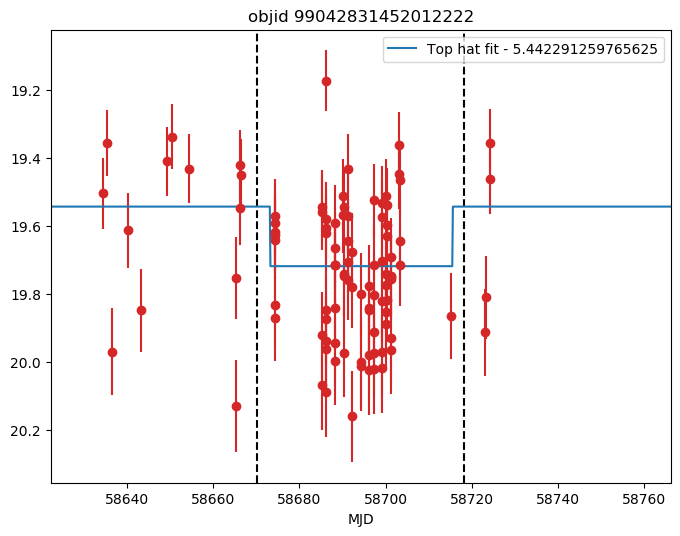

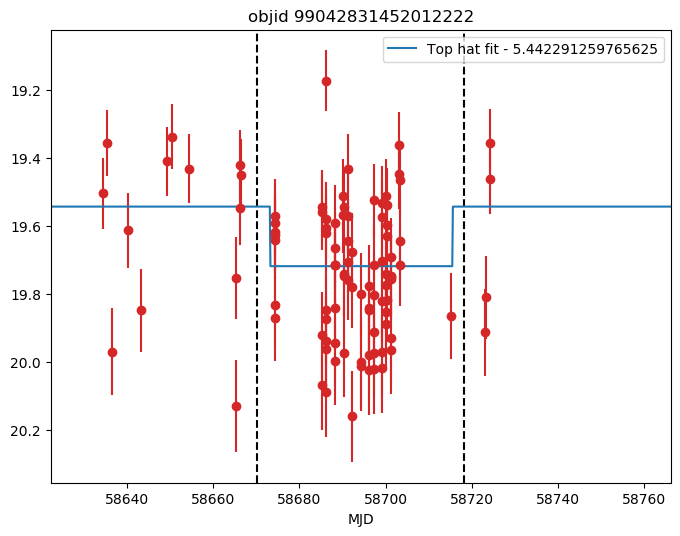

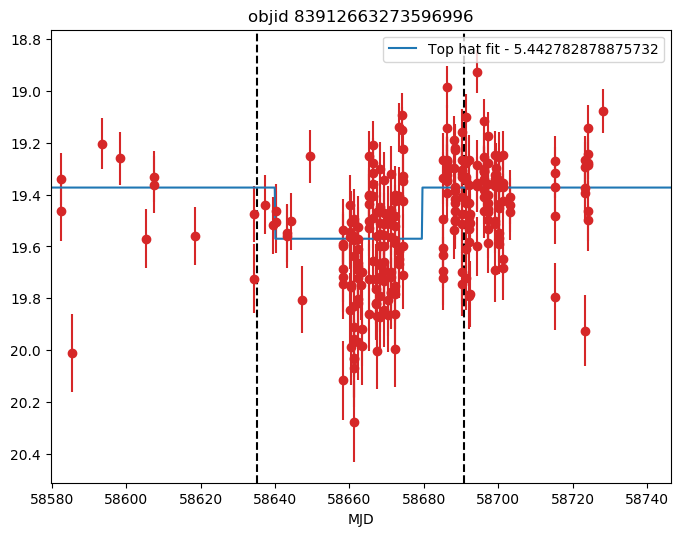

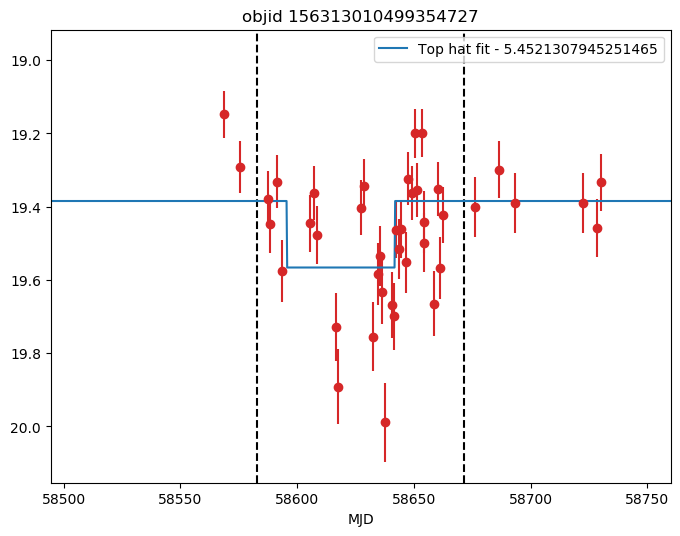

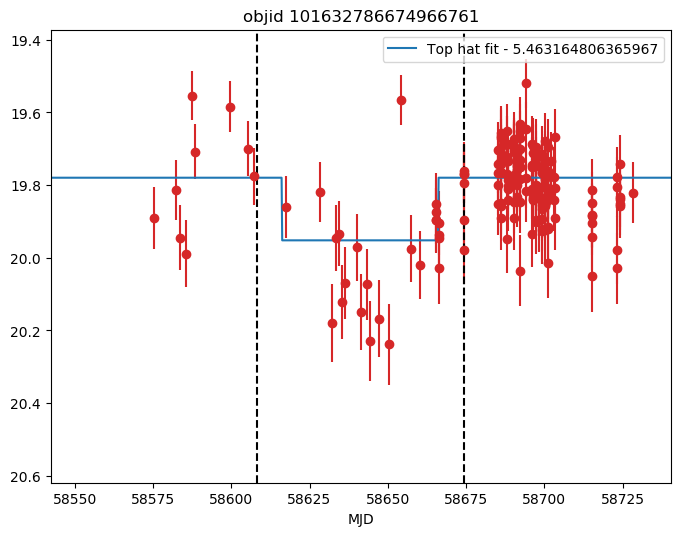

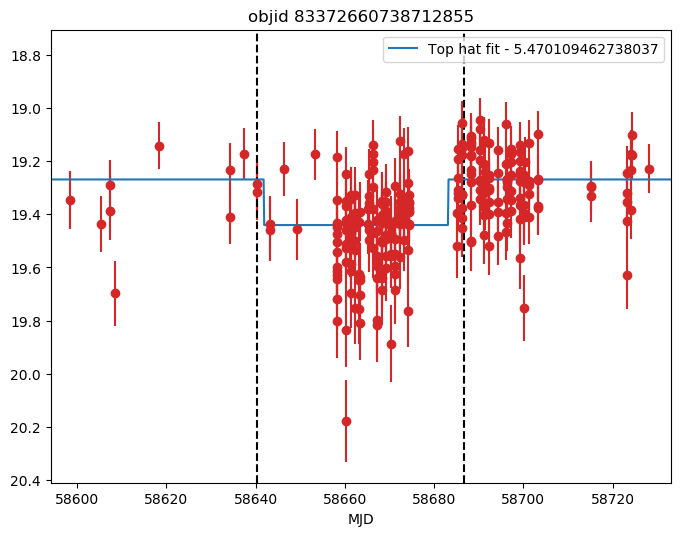

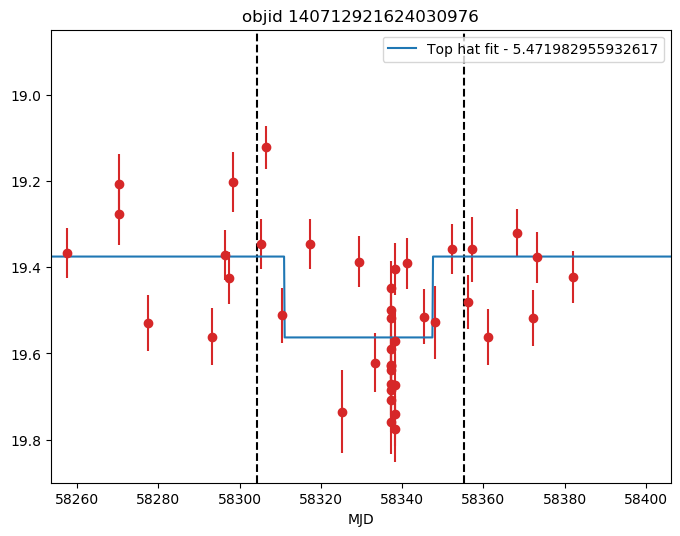

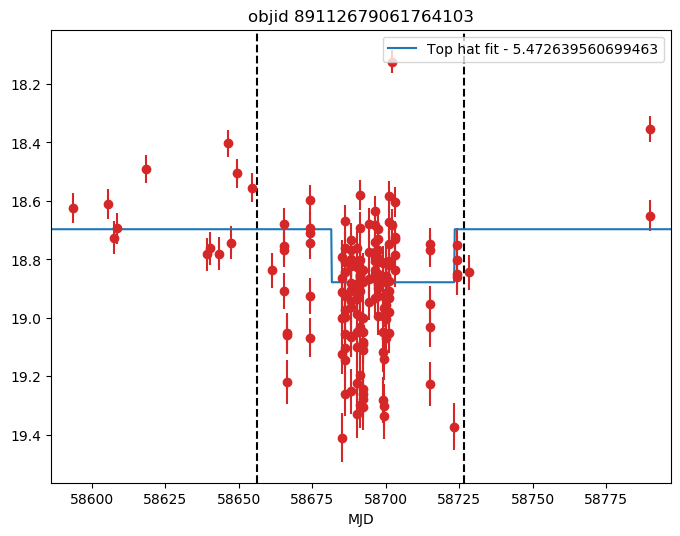

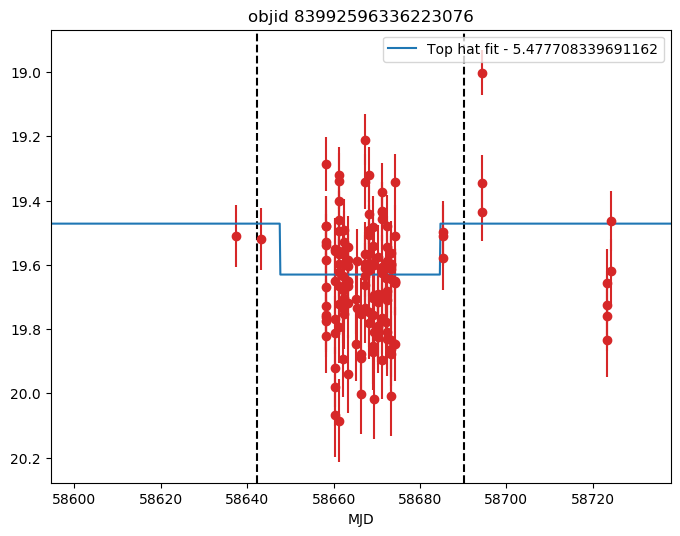

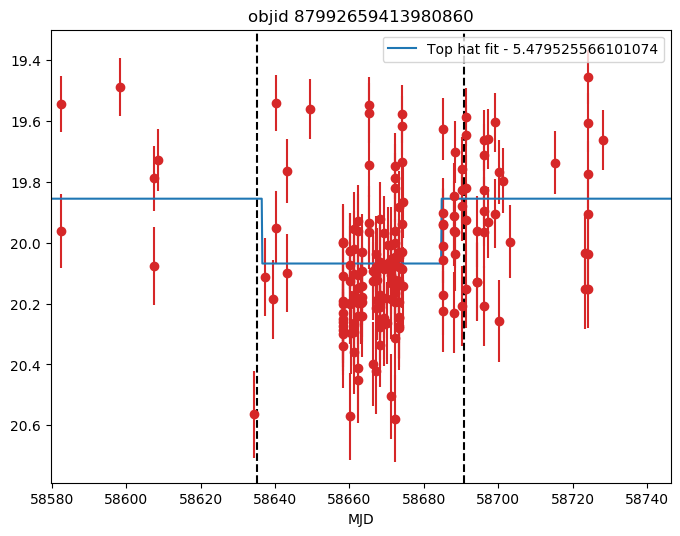

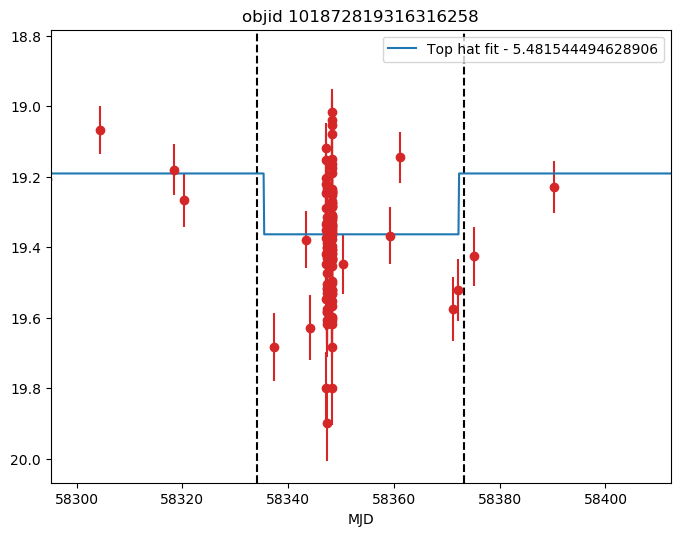

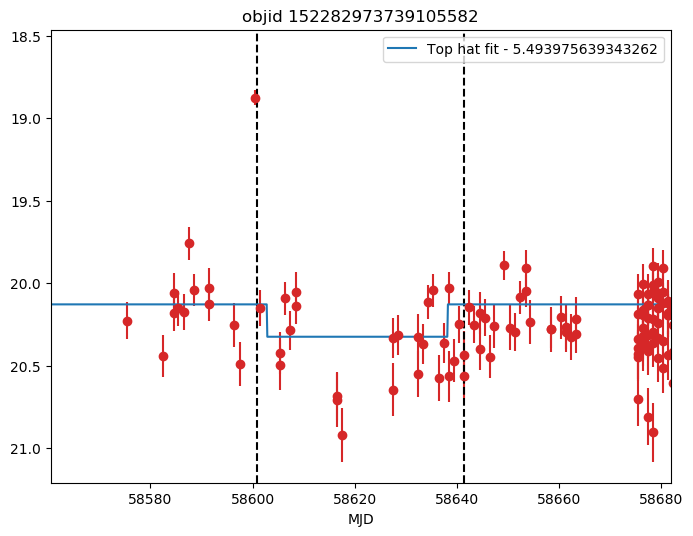

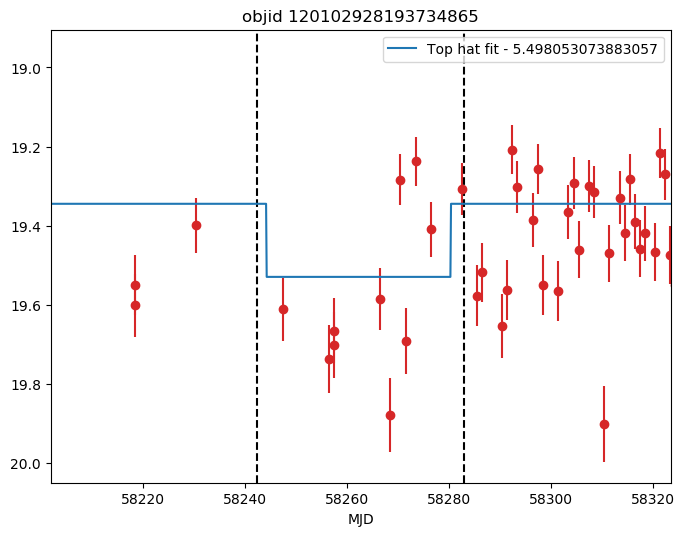

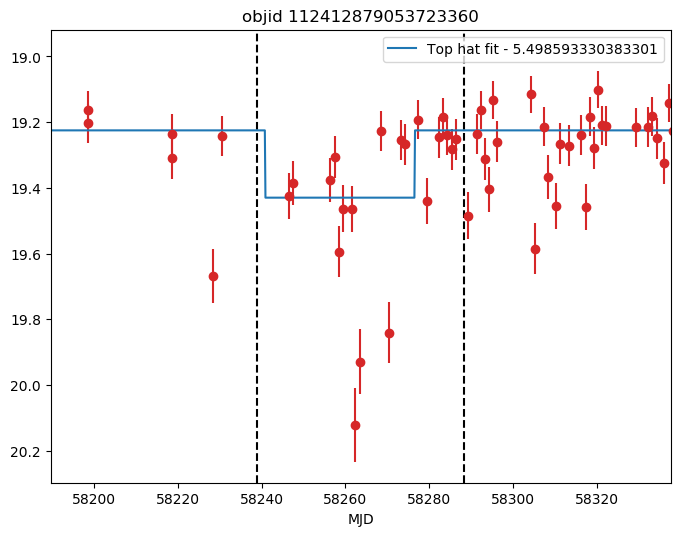

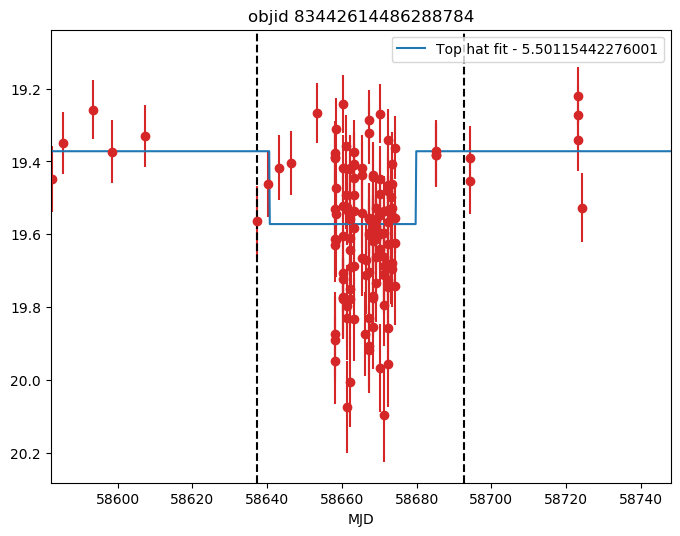

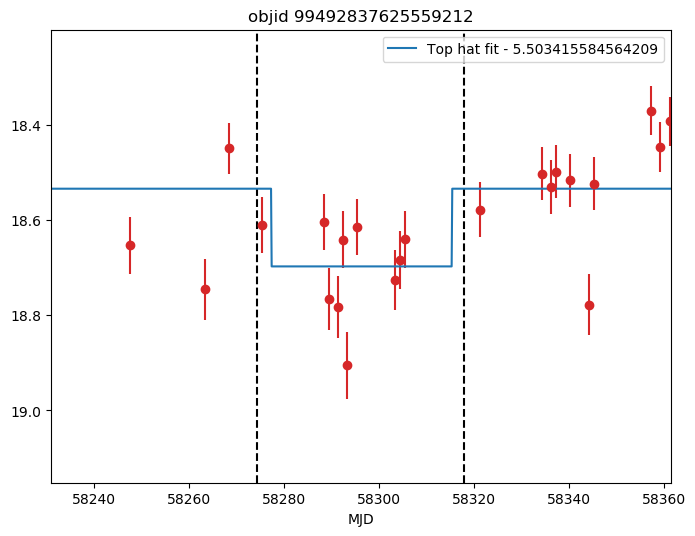

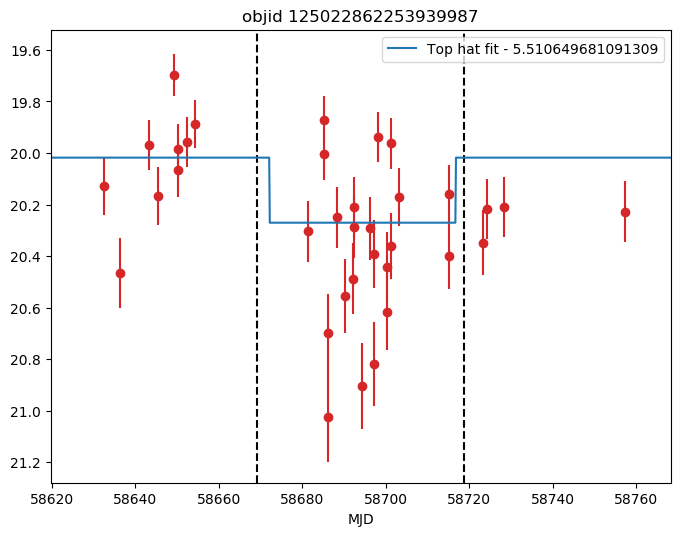

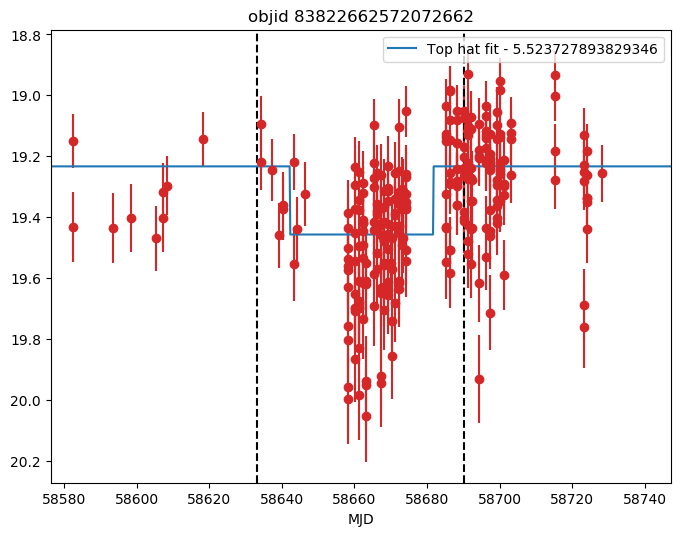

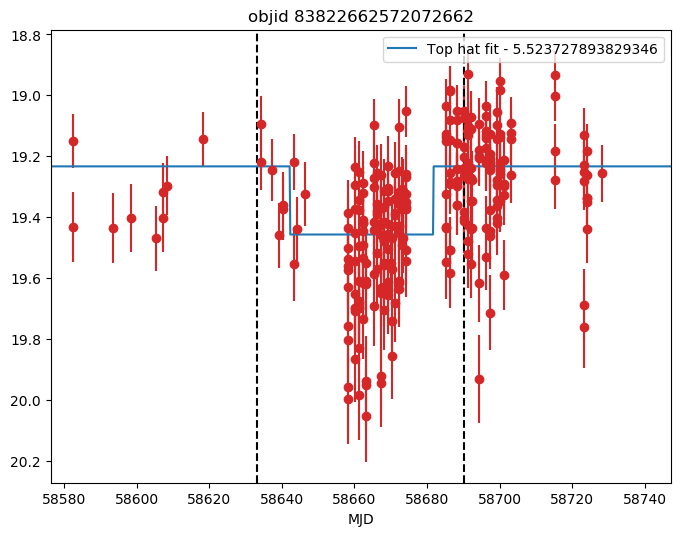

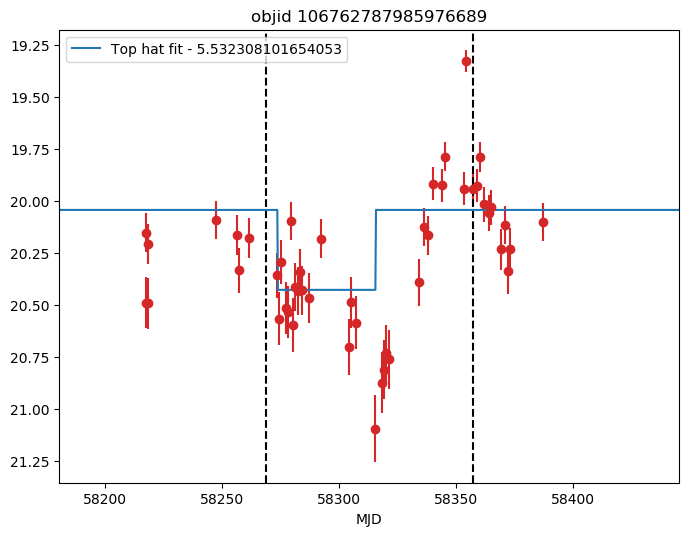

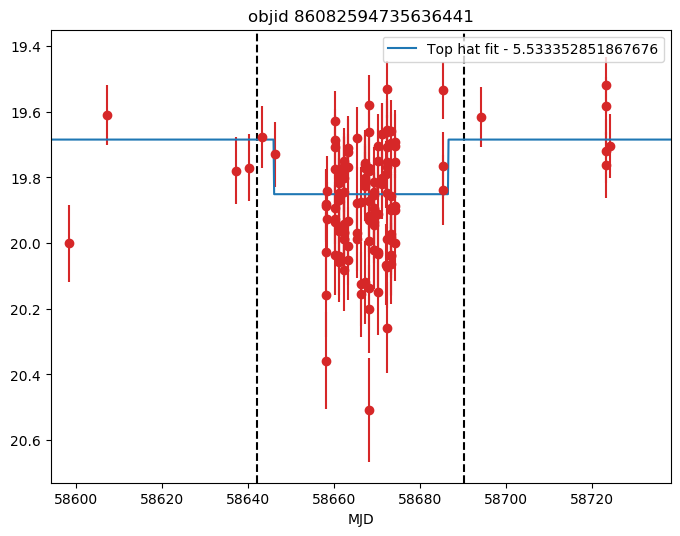

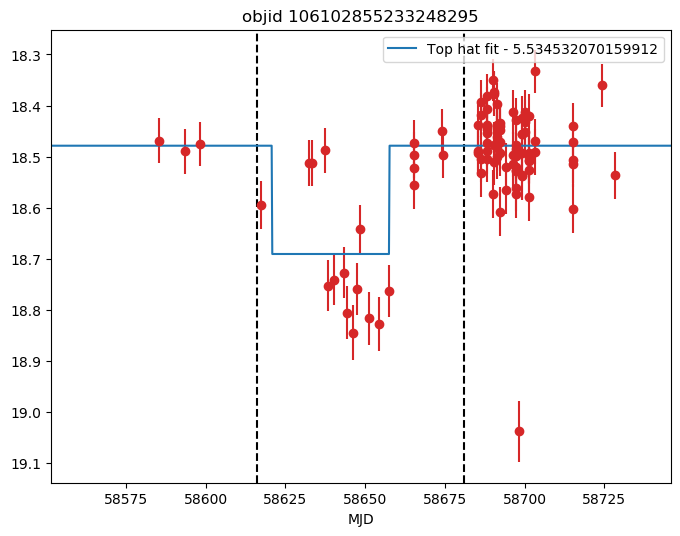

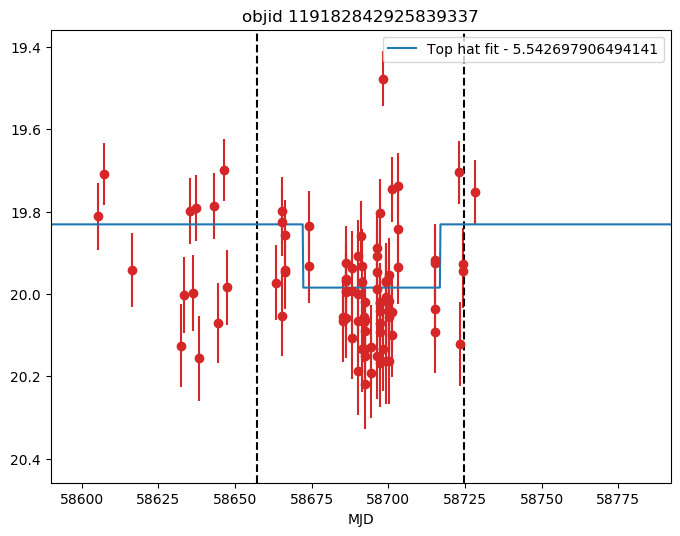

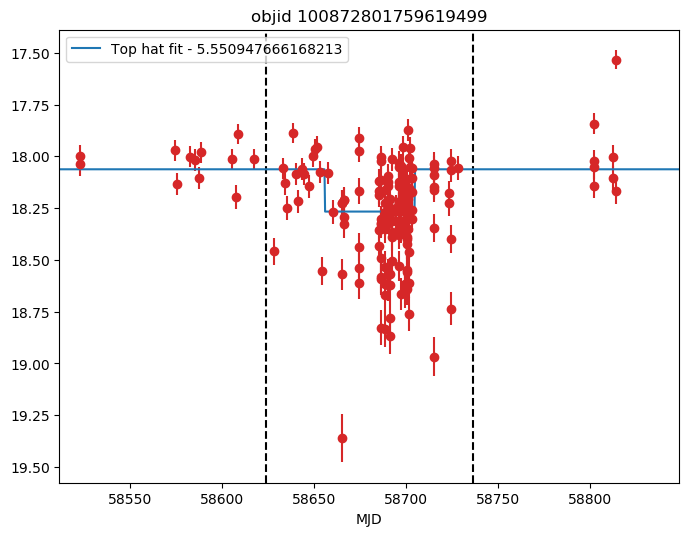

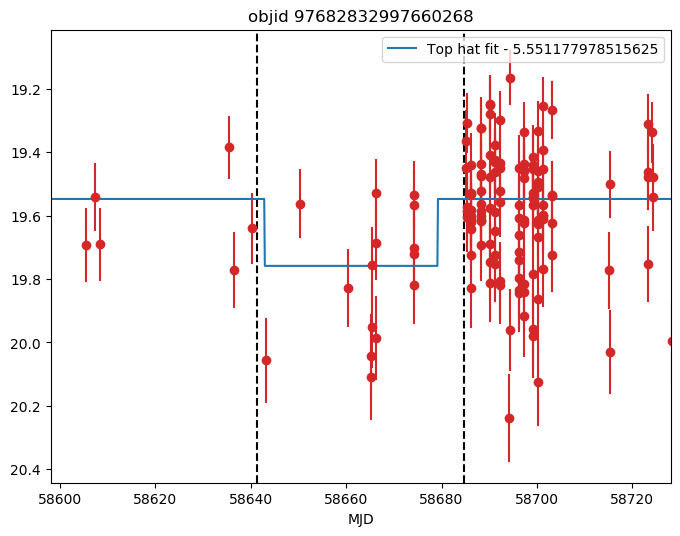

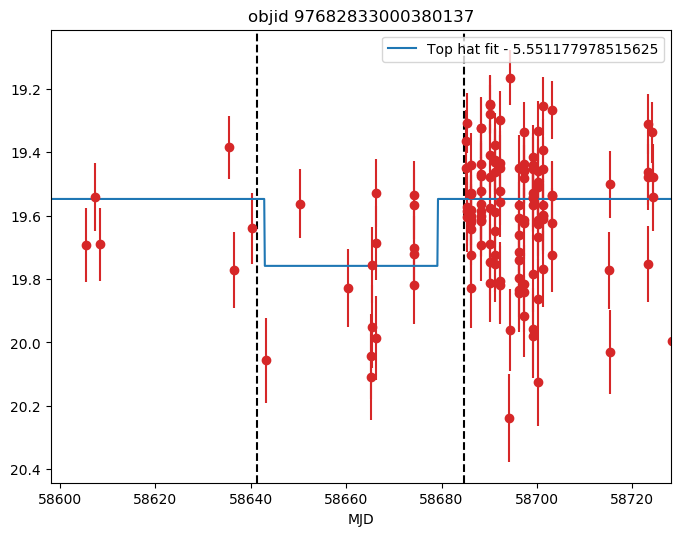

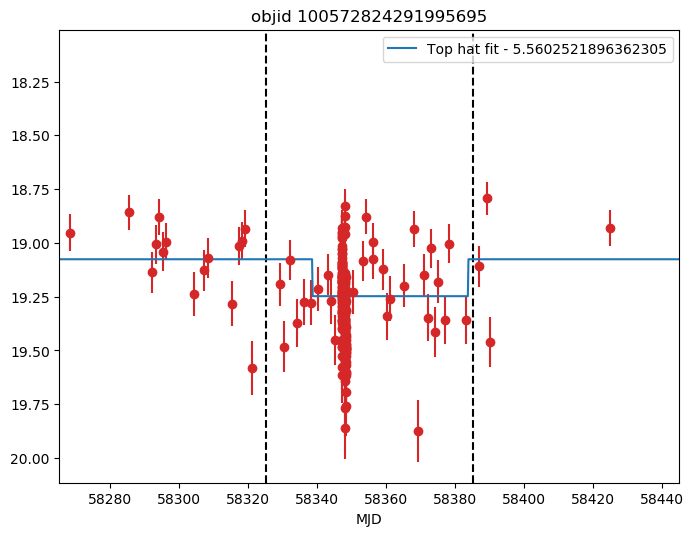

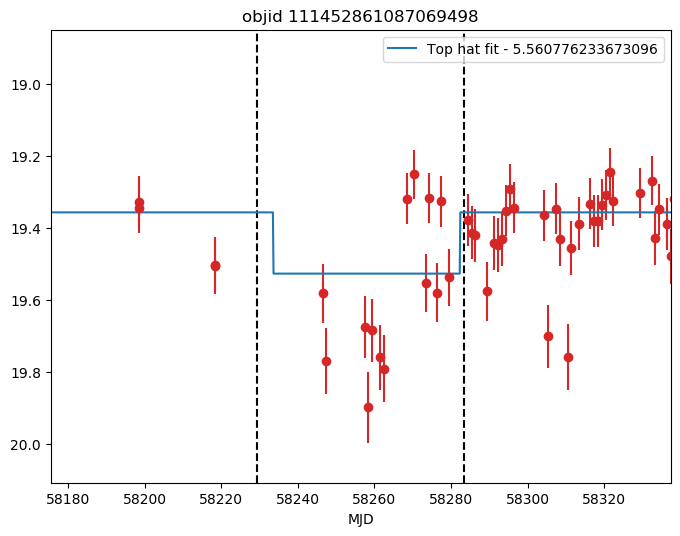

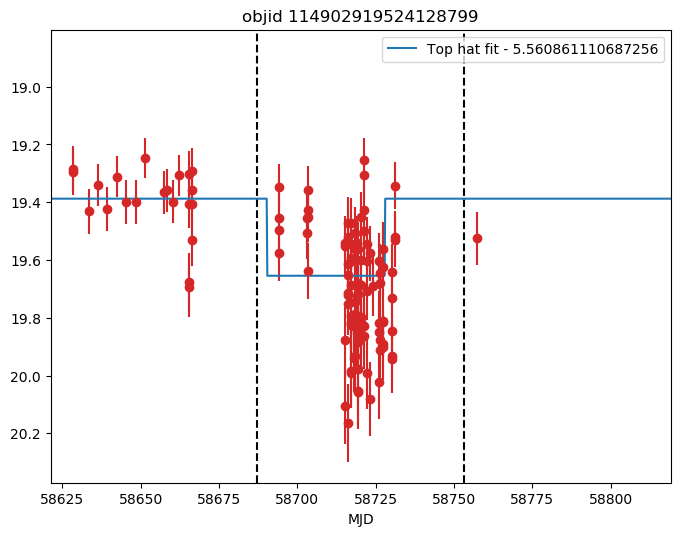

In [467]:
for i in range(100, 150):
    plot_top_hat_row(sig_df_top_hat[cut_top_hat].iloc[i])

135272885094891884
top hat fit: 5.305235862731934
length: 45.36328125

119562975826285932
top hat fit: 5.213407516479492
length: 45.96875


    